# Import Python Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Import Dataset

In [2]:
ds = pd.read_csv('F:/data_glacier_internship/week4/dataset/SPAM text message 20170820 - Data.csv')

# Explore and Understand the dataset

In [3]:
ds.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The dataset contains two columns and both contains categorical values

In [4]:
ds.shape

(5572, 2)

The dataset contains 5572 observations, and 2 features.

In [5]:
ds.isnull().sum()

Category    0
Message     0
dtype: int64

Good news! It's a complete dataset. It means the dataset doesn't contain any null values.

In [6]:
ds['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

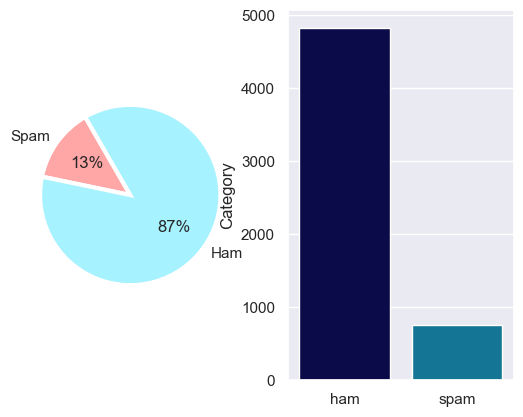

In [7]:
class_labels = ['Spam', 'Ham']
data_sizes = [747, 4825]
colors = ['#ffa6a6', '#a6f2ff']

plt.subplot(1, 2, 1)
plt.pie(data_sizes, labels = class_labels, startangle=120, autopct='%1.0f%%', colors=colors, wedgeprops={'linewidth':3,'edgecolor':'white'})

plt.subplot(1, 2, 2)
sns.barplot(x = ds['Category'].unique(), y = ds['Category'].value_counts(), palette= 'ocean')

plt.show()

In the dataset, in total 13% of the total messages are spam and the rest (87%) is ham messages.

# Preprocessing the dataset

In [8]:
#Convert text to lowercase:
def convert_text_to_lowercase(text):
    return text.lower()

#Remove URLs from text:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

#Remove punctuations from text:
def remove_punctuation(text):
    # Create a translator object to remove punctuation
    translator = text.maketrans('', '', string.punctuation)
    return text.translate(translator)

#Remove stopwords from text:
def remove_stopwords(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Get a list of stopwords in English
    stopwords_list = stopwords.words('english')
    # Use a list comprehension to remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    # Join the filtered words to form the final text
    filtered_text = ' '.join(filtered_words)
    return filtered_text

#Stemming on text:
def perform_stemming(text):
    stemmer = PorterStemmer()
    # Tokenize the text
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [9]:
ds['Message'] = ds['Message'].apply(convert_text_to_lowercase)
ds['Message'] = ds['Message'].apply(remove_urls)
ds['Message'] = ds['Message'].apply(remove_punctuation)
ds['Message'] = ds['Message'].apply(remove_stopwords)
ds['Message'] = ds['Message'].apply(perform_stemming)

In [10]:
#Let's not look into the dataset once again:
ds.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though


# Create Train and Test set

In [11]:
# Assign the features and target variables
X = ds["Message"].values
y = ds['Category'].values

# Split the data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
print('The length of the trainset is: ',len(X_train))

The length of the trainset is:  4457


In [13]:
print('The length of the trainset is: ',len(X_test))

The length of the trainset is:  1115


In [14]:
# Define the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the vectorizer on the train data
X_train = tfidf.fit_transform(X_train).toarray()

# Transform the test data using the fitted vectorizer
X_test = tfidf.transform(X_test).toarray()

In [15]:
# save the model to disk
filename = 'F:/data_glacier_internship/week4/model/tfidf_vectorizer.pkl'
pickle.dump(tfidf, open(filename, 'wb'))

# Define training and testing a model

In [17]:
def train_model(model, model_file):
    # Fit the model on the train data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Compute evaluation metrics
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
    
    # Print evaluation metrics
    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')
    print(f'F1 Score of the model: {f1}')
    print(f'Confusion matrix : {confusion_matrix(y_test, y_pred)}')
    
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f'Model saved to {model_file}')

# Define, Train, Test, and Save a model

In [18]:
model_file = 'F:/data_glacier_internship/week4/model/trained_model.pkl'

rfc = RandomForestClassifier(n_estimators= 300)
train_model(rfc, model_file)

Random Forest Classifier performed really well with the dataset. The accuracy of the model is almost 98%.

# Test the model

In [19]:
with open(model_file, 'rb') as f:
    loaded_model = pickle.load(f)

In [20]:
# load the model from disk
loaded_tfidf = pickle.load(open(filename, 'rb'))

In [25]:
comment = ["WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."]
comment = np.asarray(comment)
comment = loaded_tfidf.transform(comment).toarray()

In [26]:
comment.shape

(1, 7051)

In [27]:
pred_test = loaded_model.predict(comment)

In [28]:
pred_test

array(['spam'], dtype=object)